In [ ]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

<div class="alert alert-danger">
<font size="5"><strong>Heat conduction - Thermal diffusion</strong></font>
</div>



<div class="alert alert-warning">
<font size="4"><strong>MATHEMATICAL FORMULATION: </strong></font>
</div>

Consider the stationray heat equation:

\begin{eqnarray*}
 \text{ div }\mathbf{q}  =  f &      \text{ in } \Omega = \Omega_0 \cup  \Omega_1,
\end{eqnarray*}

where $\mathbf{q}$ is the heat flux and $f$ denotes a heat source within the domain $\Omega$.

The thermal material is described by the following linear Fourier Law:

$$
\mathbf{q} = -\mathbf k \mathbf{\nabla} T
$$

where $u$ is the temperature and $\mathbf k$ is thermal conductivity; in the simple case of thermally isotropic material, $\mathbf k = k \mathbf I$ with $k$ the isotropic thermal conductivity. The thermal conductivity may very well depend on the temperature  itself. This will then result in a nonlinear heat equation.

**For the case of an isotropic and homogeneous body, the heat equation specializes as follows**

\begin{eqnarray*}
- k \Delta T  =  f &      \text{ in } \Omega,
\end{eqnarray*}

**where $\Delta$ is the standard Laplace operator.**

Equation (7) is completed by proper boundary conditions. For simplicity, we consider the boundary value problem, that is,
$$
\left\{
\begin{array}{ll}
T = T_0 & \text{ on }  \Gamma_D, \\
k \nabla T \cdot {\bf n} = g & \text{ on }  \Gamma_N.
\end{array}
\right.$$

Here, $\Gamma_D \subset \partial \Omega$ denotes the part of the boundary where we prescribe Dirichlet boundary conditions and $\Gamma_N \subset \partial \Omega$ denotes the part of the boundary where we prescribe Neumann boundary conditions. $\bf{n}$ denotes the unit normal of $\partial \Omega$ pointing outside $\Omega$.


<div class="alert alert-warning">
<font size="4"><strong>Weak formulation: </strong></font>
</div>

Let us define the spaces $V_{T_0}, V_0 \in \Omega$ as

$$ V_{T_0} := \left\{ v \in H^1(\Omega) \text{ s. t. } v = T_0 \text{ on } \Gamma_D \right\},$$

$$ V_{0} := \left\{ v \in H^1(\Omega) \text{ s. t. } v = 0 \text{ on } \Gamma_D \right\}.$$

To obtain the weak formulation, we multiply the PDE by an arbitrary function $v \in V_0$ and integrate over the domain $\Omega$ leading to

$$ -\int_{\Omega} \nabla \cdot (k \nabla T) v \, dx = \int_\Omega f v \, dx\quad \forall \; v \in V_0. $$

Then, integration by parts the non-conforming term gives

$$ \int_{\Omega} k \nabla T \cdot \nabla v \, dx - \int_{\partial \Omega} k \frac{\partial T}{\partial {\bf n} } v \, ds = \int_\Omega f v \, dx \quad \forall \; v \in V_0. $$

Finally by recalling that $ v = 0 $ on $\Gamma_D$ and that $k \frac{\partial T}{\partial {\bf n} } = g $ on $\Gamma_N$, we find the weak formulation:

*Find  $T \in V_{T_0}$ such that*
$$ \int_{\Omega_0} k \nabla T \cdot \nabla v \, dx  + \int_{\Omega_1} k \nabla T \cdot \nabla v \, dx= \int_{\Omega_0} f v \, dx + \int_{\Omega_1} f v \, dx +\int_{\Gamma_N} g v \, ds \quad \forall \; v \in V_0. $$

#  Exercise 2

Modify the previous code to solve the following the boundary value problem:

\begin{eqnarray*}
-  \text{ div }(k \mathbf{\nabla} u)   = f, &      \text{ in } &\Omega = \Omega_0 \cup \Omega_1 ,   \tag{4}\\
u = u_T, & \text{ on } & \Gamma_{top}, \tag{5}\\
u = u_B, & \text{ on } & \Gamma_{bottom}, \tag{6}\\
k\frac{\partial u}{\partial {n}} = g_R, & \text{ on } &\Gamma_{right}  , \tag{7}\\
k\frac{\partial u}{\partial {n}} = g_L, & \text{ on } &\Gamma_{left} , \tag{8}
\end{eqnarray*}

with
$$
\Omega = (0,1)^2,\quad \Omega_1 = (0.2, 1.0) \times (0.5, 0.7) \quad\text{and}\quad \Omega_0 = \Omega - \Omega_1,
$$

$$
k(x,y)=\begin{cases}
1, & \text{ on } \Omega_0,\\
0.01, & \text{ on } \Omega_1,
\end{cases}
$$

$$ f(x, y) = 1 $$
$$
u_{0}(x, y) = \begin{cases}
u_T = 5, & \text{ on } \Gamma_{top},\\
u_B = 0.0, & \text{ on } \Gamma_{bottom},
\end{cases},
$$
$$
g(x,y)=\begin{cases}
g_L = -10 e^{-(y - 0.5)^2}, & \text{ on } \Gamma_{left},\\
g_R = 1.0, & \text{ on } \Gamma_{right},
\end{cases}
$$

# Solution to Exercise 2

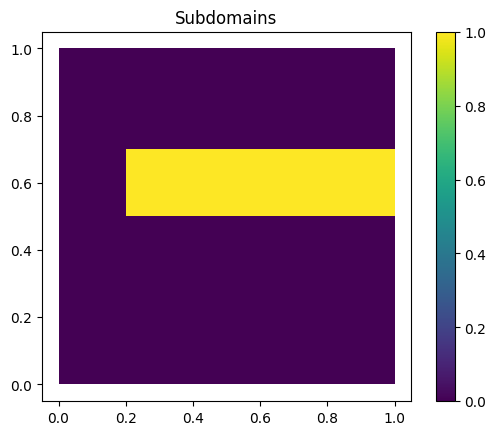

In [ ]:
from dolfin import *
import matplotlib.pyplot as plt

# Create classes for defining parts of the boundaries and the interior
# of the domain
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 1.0)

class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Top(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 1.0)

class Obstacle(SubDomain):
    def inside(self, x, on_boundary):
        return (between(x[1], (0.5, 0.7)) and between(x[0], (0.2, 1.0)))

# Initialize sub-domain instances
left = Left()
top = Top()
right = Right()
bottom = Bottom()
obstacle = Obstacle()

# Define mesh
mesh = UnitSquareMesh(10, 10)

# Initialize mesh function for interior domains

domains = MeshFunction("size_t", mesh, 2, mesh.domains())
domains.set_all(0)
obstacle.mark(domains, 1)

p=plot(domains, title="Subdomains")
plt.colorbar(p)

In [ ]:
# Initialize mesh function for boundary domains
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)

boundaries.set_all(0)

left.mark(boundaries, 1)
top.mark(boundaries, 2)
right.mark(boundaries, 3)
bottom.mark(boundaries, 4)

In [ ]:
# Define input data
k0 = Constant(1.0)
k1 = Constant(0.01)
g_L = Expression("- 10*exp(- pow(x[1] - 0.5, 2))", degree = 4)
g_R = Constant("1.0")
f = Constant(1.0)

In [ ]:
# Define function space and basis functions
V = FunctionSpace(mesh, "CG", 1)
u = TrialFunction(V)
v = TestFunction(V)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00966144 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.355463 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:----------------------------

In [ ]:
# Define Dirichlet boundary conditions at top and bottom boundaries
bcs = [DirichletBC(V, 5.0, boundaries, 2),
       DirichletBC(V, 0.0, boundaries, 4)]

In [ ]:
# Define new measures associated with the interior domains and
# exterior boundaries
dx=Measure('dx', domain=mesh, subdomain_data=domains)
ds=Measure('ds', domain=mesh, subdomain_data=boundaries)

In [ ]:
# Define variational form
a = inner(k0*grad(u), grad(v))*dx(0) + inner(k1*grad(u), grad(v))*dx(1)
L = f*v*dx(0) + f*v*dx(1) + g_L*v*ds(1) + g_R*v*ds(3)

In [ ]:
# Solve problem
u = Function(V)
solve(a == L, u, bcs)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_96ac8847e03e59c6c53084c4b9df6ba9d534cdba

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           2
  Number of exterior_facet subdomains: 4
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              3
  Coefficients:                        '[f_7, f_8, f_9]'
  Unique elements:                     'CG1(?,?), CG4(?,?), R0(?,?), Vector<2 x CG1(
                                       ?,?)>'
  Unique sub elements:                 'CG1(?,

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4f750817ecc896f3bedcb4ff8c9f3352153b1b38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00311565 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0321951 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_17d5bd7e022a45e71c9f390bd00f3f09885a1fd0

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00429869 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0147815 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_c1a44a1508926ecf46b6f2c21ef278ceddb99e6c

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0035789 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0152533 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_3720490578293ae8ad5feabedc46584f48fda4c4

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00432205 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0105228 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_beabc89512ddeda679524128dffb5706b5837a1a

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 2
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_5, f_6]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  representation: 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_82a53c44eef9856bb7c50f989a687f5eca40ef43

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0260401 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---------------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_899f792bca9deb3c3f12f5cb62d42f0545d411ea

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00278568 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0126507 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_79dd4099c4e669212673d783637297ee756e6a33

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00528502 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0138466 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_66170f427fb7c9d9caadb39d728b0be317507df5

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00525117 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.00983882 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INF

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_3c16163984060105ece1213597a717fab7eacfb4

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_16]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0313754 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:------------------------------

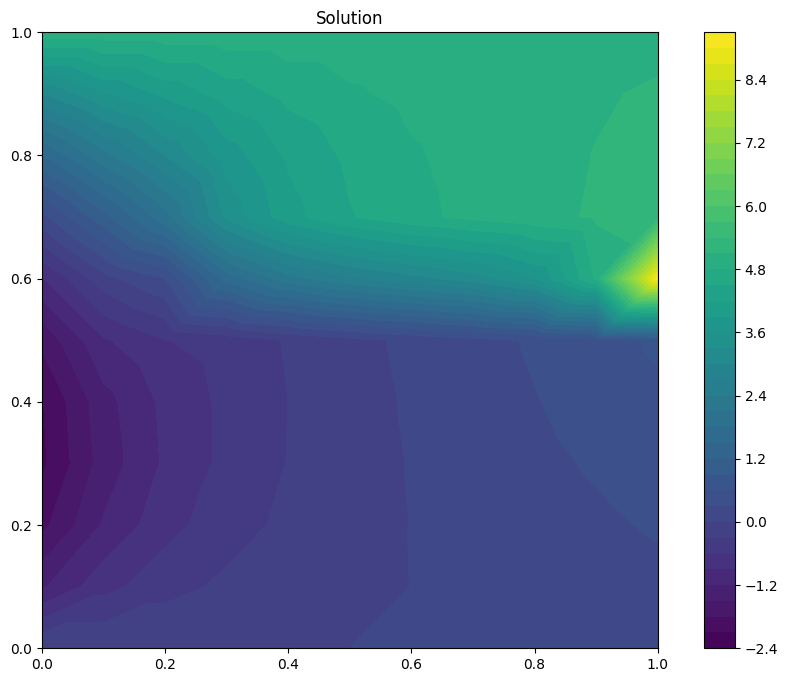

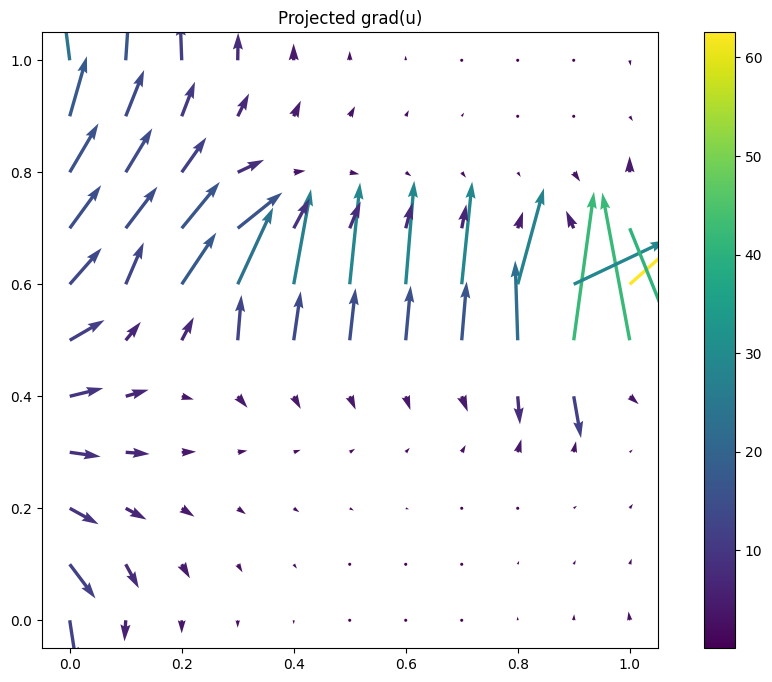

In [ ]:
# Plot solution and gradient
plt.figure(figsize=(12,8))
c = plot(u, title="Solution")
plt.colorbar(c)

plt.figure(figsize=(12,8))
p = plot(grad(u), title="Projected grad(u)")
plt.colorbar(p)

<div class="alert alert-warning">
<font size="4"><strong>#  Exercise 3: Electrostatics: Electric potential problem </strong></font>
</div>

\begin{eqnarray*}
\nabla^2 \phi = \frac{\rho}{\varepsilon_0}, &      \text{ in } &\Omega,   \tag{9}\\
\phi = 0, & \text{ on } & \partial \Omega, \tag{10}
\end{eqnarray*}

Here
$$\Omega = (-5,5)^2,$$

$$
\rho(x,y)=\begin{cases}
5.0, & \text{ on } \Omega_1 = \{ (x,y)\,\vert\, x^2+y^2 \leq r^2\},\\
0.0, & \text{otherwise}.
\end{cases}
$$

In [ ]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt
epsilon_0 = 1

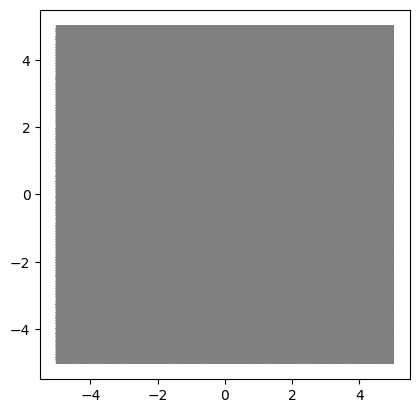

In [ ]:
class Conductor(SubDomain):
    def inside(self, x, on_boundary):
        return (pow(x[1], 2) + pow(x[0],2) - 4) < DOLFIN_EPS

conductor = Conductor()


domain_width = 10.0
circ_rad = 2.0

#Define Mesh Objects
domain = Rectangle(Point(-domain_width/2, -domain_width/2),
                    Point(domain_width/2, domain_width/2))
circ = Circle(Point(0.0, 0.0), circ_rad/2)

# Make subdomain from mesh elements
domain.set_subdomain(2, circ)

# Generate Mesh
mesh = generate_mesh(domain, 100)
plot(mesh)

# Define subdomains
subdomain_markers = MeshFunction('size_t', mesh, 2, mesh.domains())

conductor.mark(subdomain_markers, 2)

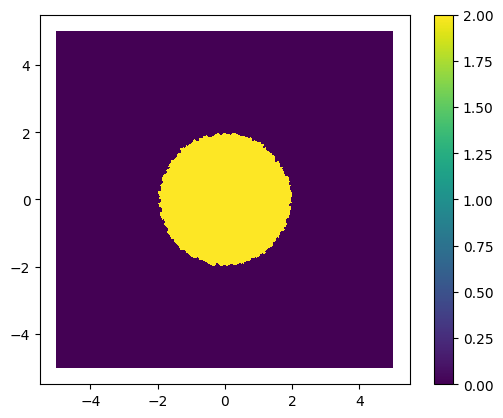

In [ ]:
p=plot(subdomain_markers)
plt.colorbar(p)

In [ ]:
dx = Measure('dx', domain=mesh, subdomain_data=subdomain_markers)
V0 = FunctionSpace(mesh, 'DG', 0)
V = FunctionSpace(mesh, 'P', 2)

In [ ]:
def boundary(x, on_boundary):
    return on_boundary
outer_boundary = DirichletBC(V, Constant(0), boundary)
bcs =[outer_boundary]

In [ ]:
class rho(UserExpression):
    def __init__(self, markers, **kwargs):
        self.markers = markers
        super().__init__(**kwargs)
    def eval_cell(self, values, x, cell):
        if self.markers[cell.index] == 2:
            values[0] = 5
        else:
            values[0] = 0

charge_density = rho(subdomain_markers, degree=1)

In [ ]:
plt.figure(figsize=(6,6))
#plot(mesh, linewidth=0.5)
p = plot(project(charge_density, V0))
plt.colorbar(p)
plt.show()

In [ ]:
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v)) * dx
L = (1/epsilon_0)*charge_density * v * dx
u = Function(V)
solve(a == L, u, bcs)

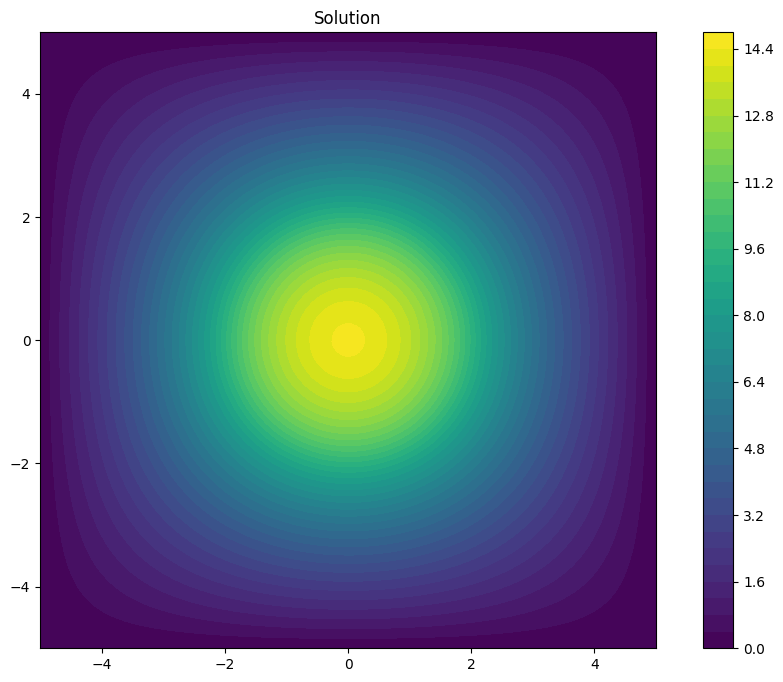

In [ ]:
%matplotlib inline
# Plot solution and gradient
plt.figure(figsize=(12,8))
c = plot(u, title="Solution")
plt.colorbar(c)

# Computing convergence rates

Define the element size $h = 1/n$, where $n$ is the number of cell divisions in the $x$ and $y$ directions. We perform experiments with $h_0 > h_1 > h_2 > \cdots  $ and compute the corresponding errors $ E_0, E_1, E_2 $ and so forth. Assuming $E_i = C h^r_i$ for unknown constants $C$ and $r$, we can compare two consecutive experiments, $E_{i−1} = C h^r_{i-1}$ and $E_i = C h^r_i$, and solve for $r$:

$$
\begin{equation*}
r = {\ln(E_i/E_{i-1})\over\ln (h_i/h_{i-1})}
\end{equation*}
$$

The $r$ values should approach the expected convergence rate (typically the polynomial degree + 1 for the $L_2$-error) as i increases.




In [ ]:
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np

def excercise_err(N):
    # to plot the result in the Notebook
    %matplotlib inline
    #
    #  Create a triangular mesh on the unit square.
    #
    my_mesh = UnitSquareMesh ( N, N )
    #
    #  Define the function space.
    #
    V = FunctionSpace ( my_mesh, 'P', 1 )
    #
    #  Define the exact solution using an expression:
    #
    ue = Expression('exp(-100.0*((x[0] - 0.03)*(x[0] - 0.03) + (x[1] - 0.03)*(x[1] - 0.03))) + exp(-1000.0*((x[0] - 1.0)*(x[0] - 1.0) + (x[1] - 1.0)*(x[1] - 1.0)))', degree = 4 )
    #
    #  Use the expression to define the boundary condition.
    #
    def boundary ( x, on_boundary ):
        return on_boundary

    bc = DirichletBC ( V, ue, boundary )
    #
    #  Define the variational problem.
    #
    u = TrialFunction ( V )
    v = TestFunction ( V )
    #
    f = Expression ( '(400.0 - 40000.0*((x[0] - 0.03)*(x[0] - 0.03) + (x[1] - 0.03)*(x[1] - 0.03)))*exp(-100.0*((x[0] - 0.03)*(x[0] - 0.03) + (x[1] - 0.03)*(x[1] - 0.03))) + (4000.0 - 4000000.0*((x[0] - 1.0)*(x[0] - 1.0) + (x[1] - 1.0)*(x[1] - 1.0)))*exp(-1000.0*((x[0] - 1.0)*(x[0] - 1.0) + (x[1] - 1.0)*(x[1] - 1.0)))', degree = 4 )
    #
    a = dot ( grad ( u ), grad ( v ) ) * dx
    L = f * v * dx
    #
    #  Compute the solution.
    #
    uh = Function ( V )
    solve ( a == L, uh, bc )
    #
    #  Use the expression to compute the error in the L2 norm.
    #
    error_L2 = errornorm ( ue, uh, 'L2' )
    print ( '  error_L2  =', error_L2 )

    # H1 seminorm
    error_H1 = errornorm(ue, uh, 'H10')
    print ( '  error_H1  =', error_H1 )
    #
    #  Use the expression to compute the maximum error at mesh vertices.
    #
    vertex_values_u_exact_expr = ue.compute_vertex_values ( my_mesh )
    vertex_values_uh = uh.compute_vertex_values ( my_mesh )
    error_max = np.max ( np.abs ( vertex_values_u_exact_expr - vertex_values_uh ) )
    excercise_err.h = 1./N
    excercise_err.error_L2 = error_L2
    excercise_err.vertex_values_uh = vertex_values_uh

excercise_err(12)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_260cf584d91d85e4640fae1f794bb00591898efb

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_110]'
  Unique elements:           'CG1(?,?), CG4(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), CG4(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 5
INFO:FFC:  quadrature_degree: 5
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0309443 seconds.

INFO:FFC:Compiler stage

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_6d178efb7219a9d3a72860e27d0bb2cc12542b0f

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0264862 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_76fc3cd9625812038c7471125b47cc4c7ae9ad4e

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00720406 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.660868 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_6ce8a510087f4e034b86fc6d0bf27a775643b273

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    1
  Coefficients:              '[f_133]'
  Unique elements:           'DG4(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'DG4(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 8
INFO:FFC:  quadrature_degree: 8
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0282664 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_8f9acf292fa7994d298cc8c76ab5884f206fd987

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00340915 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0489869 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

  error_L2  = 0.027440989827104467
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_55dc88cf5f767e48db27147c6a7f07fe9025be7d

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    1
  Coefficients:              '[f_146]'
  Unique elements:           'DG4(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'DG4(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 6
INFO:FFC:  quadrature_degree: 6
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0291789 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----------------------

  error_H1  = 1.1036337403433598


In [ ]:
#the iteration over different step sizes
n_l = [4, 8, 16, 32]
step_size = []
error_l = []
uh_ar = []
for n in n_l:
    excercise_err(n)
    step_size.append(excercise_err.h)
    error_l.append(excercise_err.error_L2)
    uh_ar.append(excercise_err.vertex_values_uh)

  error_L2  = 0.11604359385325462
  error_H1  = 1.572647925827811
  error_L2  = 0.05209032599985028
  error_H1  = 1.2892982938813964
  error_L2  = 0.01451451060902928
  error_H1  = 0.8480786278064446
  error_L2  = 0.004613924811905278
  error_H1  = 0.48821221576375046
